2017-11-22 11:40:47.484548 Start.
Computing per-channel energy normalization (PCEN) for BirdVox-70k clips.
Unit: unit01.
Augmentation: original.

h5py version: 2.6.0
librosa version: 0.5.1

unit01_941034384_08564_1_original


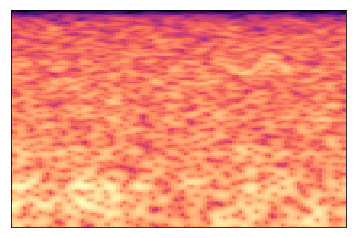

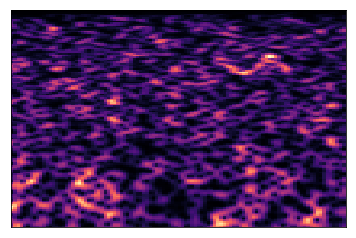

In [39]:
import datetime
import h5py
import librosa
import numpy as np
import os
import sys
import time

sys.path.append("../src")
import localmodule


# Define constants.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
sample_rate = localmodule.get_sample_rate()
args = ["original", "0", "unit01"]
aug_str = args[0]
instance_id = int(args[1])
instance_str = str(instance_id)
unit_str = args[2]
if aug_str == "original":
    instanced_aug_str = aug_str
else:
    instanced_aug_str = "-".join([aug_str, instance_str])
pcen_settings = localmodule.get_pcen_settings()


# Print header.
start_time = int(time.time())
print(str(datetime.datetime.now()) + " Start.")
print("Computing per-channel energy normalization (PCEN) for " +\
    dataset_name + " clips.")
print("Unit: " + unit_str + ".")
print("Augmentation: " + instanced_aug_str + ".")
print("")
print("h5py version: {:s}".format(h5py.__version__))
print("librosa version: {:s}".format(librosa.__version__))
print("")


# Open HDF5 container of waveforms.
hdf5_dataset_name = "_".join([dataset_name, "hdf5"])
hdf5_dir = os.path.join(data_dir, hdf5_dataset_name)
in_aug_dir = os.path.join(hdf5_dir, aug_str)
hdf5_name = "_".join([dataset_name, instanced_aug_str, unit_str])
in_path = os.path.join(in_aug_dir, hdf5_name + ".hdf5")
in_file = h5py.File(in_path, "r")
sample_rate = in_file["sample_rate"].value


# Create HDF5 container of PCENs.
pcen_name = "_".join([dataset_name, "clip-pcen"])
pcen_dir = os.path.join(data_dir, pcen_name)
os.makedirs(pcen_dir, exist_ok=True)
out_aug_dir = os.path.join(pcen_dir, aug_str)
os.makedirs(out_aug_dir, exist_ok=True)
out_path = os.path.join(out_aug_dir, hdf5_name + ".hdf5")
os.remove(out_path)
out_file = h5py.File(out_path)


# Copy over metadata.
out_file["dataset_name"] = localmodule.get_dataset_name()
out_file["unit"] = unit_str
out_file["augmentation"] = aug_str
out_file["instance"] = instance_id
out_file["utc_start_time"] = in_file["utc_start_time"].value
gps_group = out_file.create_group("gps_coordinates")
gps_group["latitude"] = in_file["gps_coordinates"]["latitude"].value
gps_group["longitude"] = in_file["gps_coordinates"]["longitude"].value
settings_group = out_file.create_group("pcen_settings")
settings_group["fmax"] = pcen_settings["fmax"]
settings_group["fmin"] = pcen_settings["fmin"]
settings_group["hop_length"] = pcen_settings["hop_length"]
settings_group["n_fft"] = pcen_settings["n_fft"]
settings_group["n_mels"] = pcen_settings["n_mels"]
settings_group["sr"] = pcen_settings["sr"]
settings_group["win_length"] = pcen_settings["win_length"]
settings_group["window"] = pcen_settings["window"]
settings_group["pcen_delta_denominator"] = pcen_settings["pcen_delta_denominator"]
settings_group["pcen_time_constant_frames"] = pcen_settings["pcen_time_constant_frames"]
settings_group["pcen_norm_exponent"] = pcen_settings["pcen_norm_exponent"]
settings_group["pcen_power"] = pcen_settings["pcen_power"]


# List clips.
lms_group = out_file.create_group("pcen")
clip_names = list(in_file["waveforms"].keys())


clip_name = clip_names[-72]

# Load waveform.
waveform = in_file["waveforms"][clip_name].value
waveform = waveform * (2**32)

# Resample to 22050 Hz.
waveform = librosa.resample(
    waveform, sample_rate, pcen_settings["sr"])

# Compute Short-Term Fourier Transform (STFT).
stft = librosa.stft(
    waveform,
    n_fft=pcen_settings["n_fft"],
    win_length=pcen_settings["win_length"],
    hop_length=pcen_settings["hop_length"],
    window=pcen_settings["window"])

# Compute squared magnitude coefficients.
abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)

# Gather frequency bins according to the Mel scale.
melspec = librosa.feature.melspectrogram(
    y=None,
    S=abs2_stft,
    sr=pcen_settings["sr"],
    n_fft=pcen_settings["n_fft"],
    n_mels=pcen_settings["n_mels"],
    htk=True,
    fmin=pcen_settings["fmin"],
    fmax=pcen_settings["fmax"])

smoothed_melspec = pcen_smooth(melspec, pcen_settings["pcen_time_constant_frames"])
pcen_gain = (smoothed_melspec + 1) ** pcen_settings["pcen_norm_exponent"]
pcen_melspec = melspec * pcen_gain
pcen_offset = pcen_melspec.max() / 10.0
pcen_melspec =\
    (pcen_melspec + pcen_offset) ** pcen_settings["pcen_power"] -\
    pcen_offset ** pcen_settings["pcen_power"]
    
    
%matplotlib inline
import librosa.display
from matplotlib import pyplot as plt

print(clip_name)
clip_width = 104
clip_mid = int(melspec.shape[1] / 2)
clip_start = clip_mid - int(clip_width / 2)
clip_stop = clip_mid + int(clip_width / 2)
logmelspec = 0.5 * librosa.logamplitude(melspec, ref=1.0)
plt.figure(); librosa.display.specshow(logmelspec[:, clip_start:clip_stop])
#plt.figure(); librosa.display.specshow(pcen_gain)
plt.figure(); librosa.display.specshow(pcen_melspec[:, clip_start:clip_stop])

In [26]:
melspec.shape

(128, 345)

In [4]:
def pcen_smooth(melspec, time_constant_frames):
    smoothed_melspec = melspec.copy()
    coeff = 1.0 / time_constant_frames
    num_cols = melspec.shape[1]
    for col in np.arange(1, num_cols):
        smoothed_melspec[:, col] =\
            smoothed_melspec[:, col - 1] +\
            (melspec[:, col] - smoothed_melspec[:, col - 1]) * coeff
    return smoothed_melspec

In [15]:
np.max(waveform)

0.10450546

In [19]:
waveform

array([-51872305.33593159, -62454981.0085509 , -46982902.50199408, ...,
        -4876342.84805187,  12445661.809635  ,  10013188.75978121])